In [1]:
import batoid
import galsim
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

In [2]:
filename = os.path.join(batoid.datadir, 'HSC', 'HSC.yaml')
config = yaml.load(open(filename))
fiducial_telescope = batoid.parse.parse_optic(config['opticalSystem'])

In [3]:
# parameters
defocus = 900e-6
theta_x = np.deg2rad(0.74)
theta_y = np.deg2rad(0.0)

In [4]:
telescope = fiducial_telescope.withGloballyShiftedOptic('SubaruHSC.HSC', [0,0,defocus])

[[ -6.19344031e-02  -2.25768724e-07]
 [  2.63224016e-08  -5.76777582e-02]]
[[-0.0597682 -0.       ]
 [-0.        -0.0597682]]
[[ -9.55848407e-03   6.52666007e-09]
 [  1.65408511e-07  -9.91523025e-03]]


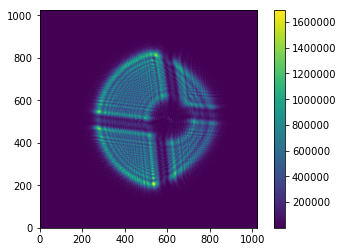

In [21]:
# Make an fft PSF
fftPSF = batoid.fftPSF(telescope, theta_x, theta_y, 750e-9, nx=512, pad_factor=2)
plt.imshow(fftPSF.array)
plt.colorbar()

paraxialPrimitiveVectors = np.sign(fftPSF.primitiveVectors[0,0]) * np.eye(2) * np.sqrt(np.abs(np.linalg.det(fftPSF.primitiveVectors)))

print(fftPSF.primitiveVectors*1e6/15) # units of HSC pixels
print(paraxialPrimitiveVectors*1e6/15)

dGnomicDx = batoid.psf.dthdr(telescope, 0.01, 0.0, 750e-9)
dSphericalDGnomic = batoid.utils.dSphericalDGnomic(0.01, 0.0)
paraxialFFTSphericalPrimitives = np.dot(
    np.dot(
        paraxialPrimitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(paraxialFFTSphericalPrimitives)

In [22]:
# Also use the non-paraxial lattice that comes from batoid.
print(fftPSF.primitiveVectors*1e6/15) # units of HSC pixels
nonParaxialFFTSphericalPrimitives = np.dot(
    np.dot(
        fftPSF.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(nonParaxialFFTSphericalPrimitives)

[[ -6.19344031e-02  -2.25768724e-07]
 [  2.63224016e-08  -5.76777582e-02]]
[[ -9.90491636e-03  -3.06906372e-08]
 [  1.63832852e-07  -9.56843722e-03]]


[[ -4.95475225e-01  -1.80614979e-06]
 [  2.10579213e-07  -4.61422066e-01]]
[[ -7.92393309e-02  -2.45525097e-07]
 [  1.31066281e-06  -7.65474978e-02]]


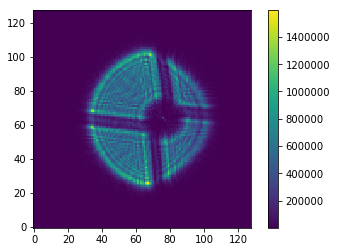

In [23]:
# Huygens, on the same grid as nonParaxialFFT
huygens = batoid.huygensPSF(telescope, theta_x, theta_y, 750e-9, 
                            nx=512,
                            nxOut=1024//8,
                            dx=fftPSF.primitiveVectors[0]*8,
                            dy=fftPSF.primitiveVectors[1]*8)
plt.imshow(huygens.array)
plt.colorbar()
print(huygens.primitiveVectors*1e6/15)
huygensSphericalPrimitives = np.dot(
    np.dot(
        huygens.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(huygensSphericalPrimitives)

[[-0.47814559 -0.        ]
 [-0.         -0.47814559]]
[[ -7.64678725e-02   5.22132805e-08]
 [  1.32326809e-06  -7.93218420e-02]]


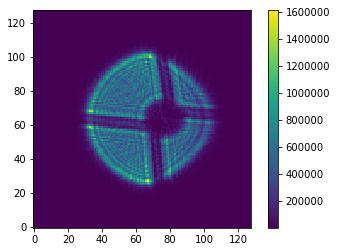

In [24]:
# Huygens, but evaluated at the same positions as paraxial
huygensParaxial = batoid.huygensPSF(telescope, theta_x, theta_y, 750e-9, 
                                    nx=512,
                                    nxOut=1024//8,
                                    dx=paraxialPrimitiveVectors[0]*8,
                                    dy=paraxialPrimitiveVectors[1]*8)
plt.imshow(huygensParaxial.array)
plt.colorbar()
print(huygensParaxial.primitiveVectors*1e6/15)
huygensParaxialSphericalPrimitives = np.dot(
    np.dot(
        huygensParaxial.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(huygensParaxialSphericalPrimitives)

In [25]:
# Make a GalSim PSF.  Just steal one of the fft arrays, and assert
# a primitive vector of wavelength/(pad_factor*pupilSize).
gsPrimitives = -np.eye(2)*750e-9/2/telescope.pupilSize * 206265
gsPSF = batoid.Lattice(np.array(fftPSF.array), gsPrimitives)

In [26]:
print(gsPrimitives)

[[-0.00943285 -0.        ]
 [-0.         -0.00943285]]


In [30]:
print(nonParaxialFFTSphericalPrimitives)

[[ -9.90491636e-03  -3.06906372e-08]
 [  1.63832852e-07  -9.56843722e-03]]


In [11]:
# First, let's just plot normalized differences

# By construction.  Difference is the anisotropic pixel scale.
np.testing.assert_allclose(paraxialFFT.array, nonParaxialFFT.array)

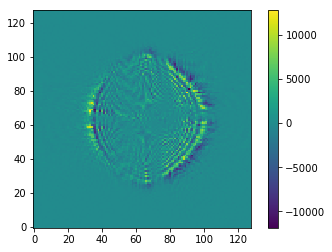

In [12]:
plt.imshow(huygens.array - nonParaxialFFT.array[::8,::8])
plt.colorbar()

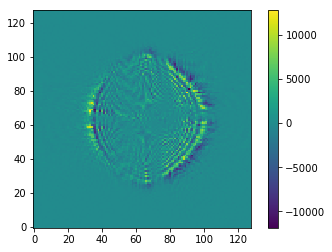

In [13]:
plt.imshow(huygensParaxial.array - paraxialFFT.array[::8,::8])
plt.colorbar()

In [14]:
# Now we can form galsim objects and project onto the same sky.
paraxialFFTObj = galsim.InterpolatedImage(
    galsim.Image(
        paraxialFFT.array[::8,::8], 
        wcs=galsim.JacobianWCS(*paraxialFFTSphericalPrimitives.ravel()*8)
    ),
    normalization='sb',
    flux=1
)

nonParaxialFFTObj = galsim.InterpolatedImage(
    galsim.Image(
        nonParaxialFFT.array[::8,::8],
        wcs=galsim.JacobianWCS(*nonParaxialFFTSphericalPrimitives.ravel()*8)
    ),
    normalization='sb',
    flux=1
)

huygensObj = galsim.InterpolatedImage(
    galsim.Image(
        huygens.array,
        wcs=galsim.JacobianWCS(*huygensSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)

huygensParaxialObj = galsim.InterpolatedImage(
    galsim.Image(
        huygensParaxial.array,
        wcs = galsim.JacobianWCS(*huygensParaxialSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)
gsObj = galsim.InterpolatedImage(
    galsim.Image(
        gsPSF.array[::8,::8],
        wcs = galsim.JacobianWCS(*gsPrimitives.ravel()*8)
    ),
    normalization='sb',
    flux=1
)

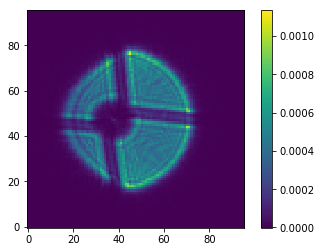

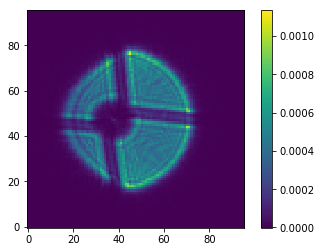

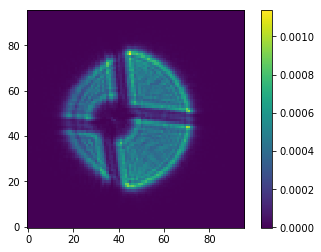

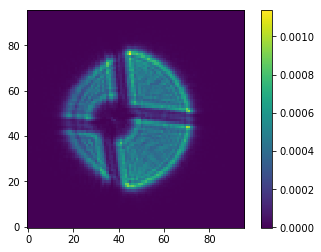

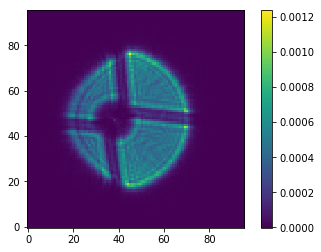

In [15]:
parFFTImg = paraxialFFTObj.drawImage(scale=0.1, nx=96, ny=96)
plt.imshow(parFFTImg.array)
plt.colorbar()
plt.show()

nonParFFTImg = nonParaxialFFTObj.drawImage(scale=0.1, nx=96, ny=96)
plt.imshow(nonParFFTImg.array)
plt.colorbar()
plt.show()

hImg = huygensObj.drawImage(scale=0.1, nx=96, ny=96)
plt.imshow(hImg.array)
plt.colorbar()
plt.show()

hParImg = huygensParaxialObj.drawImage(scale=0.1, nx=96, ny=96)
plt.imshow(hParImg.array)
plt.colorbar()
plt.show()

gsImg = gsObj.drawImage(scale=0.1, nx=96, ny=96)
plt.imshow(gsImg.array)
plt.colorbar()
plt.show()

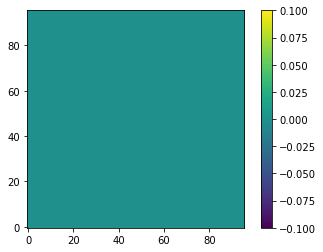

In [16]:
plt.imshow(hImg.array - hParImg.array)
plt.colorbar()

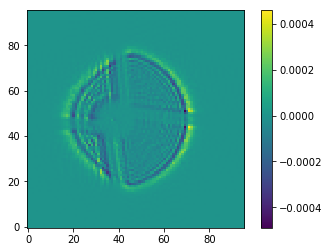

In [17]:
plt.imshow(hImg.array - gsImg.array)
plt.colorbar()

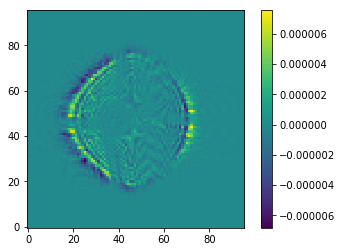

In [18]:
plt.imshow(hImg.array - nonParFFTImg.array)
plt.colorbar()